<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/HAM10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

In [2]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# Data

In [3]:
!git clone https://github.com/filmerxyz/HAM10000_split

Cloning into 'HAM10000_split'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 10065 (delta 0), reused 1 (delta 0), pack-reused 10062
Receiving objects: 100% (10065/10065), 2.57 GiB | 15.71 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (10021/10021), done.


In [4]:
train_path = '/content/HAM10000_split/train' 
val_path = '/content/HAM10000_split/val'
test_path = '/content/HAM10000_split/test'

In [5]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 6303 images belonging to 7 classes.
Found 2707 images belonging to 7 classes.
Found 1005 images belonging to 7 classes.


# Model

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(224, 224, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [9]:
model.compile(optimizer='adam' , loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS)

Epoch 1/30
197/197 [==============================] - 134s 678ms/step - loss: 1.3831 - accuracy: 0.6616 - val_loss: 1.1521 - val_accuracy: 0.6690
Epoch 2/30
197/197 [==============================] - 132s 669ms/step - loss: 1.0288 - accuracy: 0.6700 - val_loss: 0.9739 - val_accuracy: 0.6690
Epoch 3/30
197/197 [==============================] - 130s 659ms/step - loss: 1.0076 - accuracy: 0.6703 - val_loss: 0.9563 - val_accuracy: 0.6690
Epoch 4/30
197/197 [==============================] - 132s 669ms/step - loss: 0.9688 - accuracy: 0.6705 - val_loss: 1.0612 - val_accuracy: 0.6690
Epoch 5/30
197/197 [==============================] - 133s 674ms/step - loss: 0.9462 - accuracy: 0.6698 - val_loss: 0.8979 - val_accuracy: 0.6697
Epoch 6/30
197/197 [==============================] - 133s 675ms/step - loss: 0.9280 - accuracy: 0.6708 - val_loss: 0.8841 - val_accuracy: 0.6686
Epoch 7/30
197/197 [==============================] - 130s 662ms/step - loss: 0.9060 - accuracy: 0.6698 - val_loss: 0.8611 -

# Graph

## Accuracy

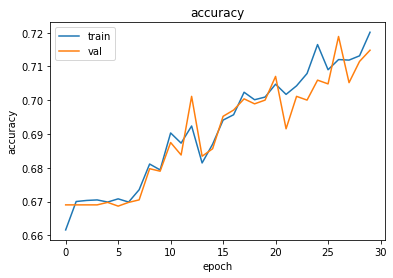

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

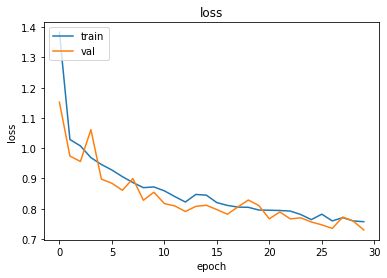

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [14]:
test_generator.reset()

In [17]:
num_test_files = len(test_generator.filenames)

In [18]:
test_labels = test_generator.classes
predictions = model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

## Confusion Matrix

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Without Normalization

Confusion matrix, without normalization
[[  1   5  10   0   0  17   0]
 [  0  18   3   0   1  30   0]
 [  0   6  26   0   4  74   0]
 [  0   5   1   0   0   6   0]
 [  0   0  10   0  20  82   0]
 [  0   4  14   0   4 649   0]
 [  0   1   0   0   1   6   7]]


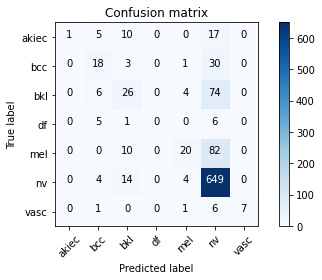

In [19]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalization

Normalized confusion matrix
[[0.03030303 0.15151515 0.3030303  0.         0.         0.51515152
  0.        ]
 [0.         0.34615385 0.05769231 0.         0.01923077 0.57692308
  0.        ]
 [0.         0.05454545 0.23636364 0.         0.03636364 0.67272727
  0.        ]
 [0.         0.41666667 0.08333333 0.         0.         0.5
  0.        ]
 [0.         0.         0.08928571 0.         0.17857143 0.73214286
  0.        ]
 [0.         0.00596125 0.02086438 0.         0.00596125 0.96721311
  0.        ]
 [0.         0.06666667 0.         0.         0.06666667 0.4
  0.46666667]]


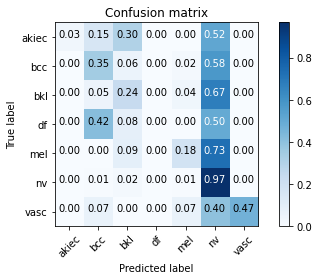

In [20]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [21]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[  1   5  10   0   0  17   0]
 [  0  18   3   0   1  30   0]
 [  0   6  26   0   4  74   0]
 [  0   5   1   0   0   6   0]
 [  0   0  10   0  20  82   0]
 [  0   4  14   0   4 649   0]
 [  0   1   0   0   1   6   7]]
Classification Report
              precision    recall  f1-score   support

       akiec       1.00      0.03      0.06        33
         bcc       0.46      0.35      0.40        52
         bkl       0.41      0.24      0.30       110
          df       0.00      0.00      0.00        12
         mel       0.67      0.18      0.28       112
          nv       0.75      0.97      0.85       671
        vasc       1.00      0.47      0.64        15

    accuracy                           0.72      1005
   macro avg       0.61      0.32      0.36      1005
weighted avg       0.69      0.72      0.66      1005



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
